In [1]:
import pandas as pd
from load_files_to_db import cf_to_stations
from file_header_types import CleanedFile, RawFile, FileHeaderType
from models import verbose_engine
from sqlalchemy.orm import sessionmaker
from models import Trip
from models import engine
import numpy as np
import matplotlib.pyplot as plt


# Data investigation/cleaning

### First off, what does the data even look like?
The raw data originally looked like this 👇

In [2]:
import helpers
helpers.get_sample_file(n=1000)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,C09E4093905089BD,classic_bike,2022-07-23 11:34:57,2022-07-23 11:45:08,Melrose St & Broadway,4801.04,Myrtle Ave & Grove St,4816.05,40.697481,-73.935877,40.699050,-73.915160,member
1,374630DB5822C392,electric_bike,2022-07-29 18:19:08,2022-07-29 18:26:50,E 68 St & 3 Ave,6896.16,E 85 St & York Ave,7146.04,40.767128,-73.962246,40.775369,-73.948034,member
2,4F73CA25880A1215,electric_bike,2022-07-16 16:30:58,2022-07-16 17:39:18,W 37 St & 10 Ave,6611.02,Knickerbocker Ave & Cooper St,4582.05,40.756604,-73.997901,40.690810,-73.904480,member
3,ECD6EE19C0CC1D31,electric_bike,2022-07-17 17:35:57,2022-07-17 18:03:36,W 37 St & 10 Ave,6611.02,6 Ave & Broome St,5610.09,40.756604,-73.997901,40.724310,-74.004730,member
4,44D0987673B9997D,classic_bike,2022-07-11 07:56:29,2022-07-11 07:59:15,E 68 St & 3 Ave,6896.16,E 66 St & Madison Ave,6969.08,40.767128,-73.962246,40.768009,-73.968453,member
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0F87E6AA53284B9F,classic_bike,2022-07-04 13:37:48,2022-07-04 13:44:31,34 St & 35 Ave,6605.08,Steinway St & Broadway,6711.13,40.756933,-73.926223,40.759058,-73.918975,casual
996,3B433CD081477953,electric_bike,2022-07-24 04:47:36,2022-07-24 05:00:46,East End Ave & E 86 St,7113.08,West End Ave & W 94 St,7524.09,40.775186,-73.944461,40.794165,-73.974124,member
997,5CFE90B3DCDFC7DE,classic_bike,2022-07-02 20:21:59,2022-07-02 20:29:46,East End Ave & E 86 St,7113.08,E 75 St & 3 Ave,6991.12,40.775186,-73.944461,40.771129,-73.957723,member
998,EC034412314B3701,electric_bike,2022-07-01 07:39:09,2022-07-01 07:51:09,Washington Pl & Broadway,5755.01,Madison Av & E 51 St,6659.09,40.729039,-73.994046,40.758630,-73.975130,member


There's a record for each trip including the start and the end of the trip, which station and some metadata about the user taking the trip and the station

However the data was too large to read directly from csvs so we had to load it to a database. A lot of the data about the details of a specific station were duplicated, so instead of loading it directly as-is, we split the data into two tables. Trips and Stations which were linked by the key "citi_station_id" -> start/end_station_id. The stations table has all the data that was otherwise duplicated (e.g. station lat/long, station_name) and we were able to add some additional metadata like when the station was first and last seen

In [3]:
trips_sample_df = pd.read_sql("select * from prod.trips limit 100", engine)
stations_df = pd.read_sql("select * from prod.stations", engine)

In [4]:
trips_sample_df

,trip_id,ride_id,started_at,ended_at,start_station_id,end_station_id,membership_status,rideable_type,filename
0,1,BBA33D73DECE976F,2021-02-26 16:38:54,2021-02-26 16:44:37,7243.04,7057.07,casual,docked_bike,extracted_data/202102-citibike-tripdata.csv
1,2,B63D7AFF9AC5B6D4,2021-02-17 11:09:11,2021-02-17 11:26:47,4214.03,4479.06,member,docked_bike,extracted_data/202102-citibike-tripdata.csv
2,3,52B829195C469D99,2021-02-26 18:33:29,2021-02-26 19:05:41,4214.03,4222.02,casual,docked_bike,extracted_data/202102-citibike-tripdata.csv
3,4,19C84ECA2B468476,2021-02-26 12:48:35,2021-02-26 13:07:24,4214.03,4479.06,member,docked_bike,extracted_data/202102-citibike-tripdata.csv
4,5,C0DDB771E70D9DF5,2021-02-25 17:23:22,2021-02-25 17:28:20,6131.12,6398.06,member,docked_bike,extracted_data/202102-citibike-tripdata.csv
...,...,...,...,...,...,...,...,...,...
95,96,0EC3B2ADC8644A20,2021-02-28 17:41:45,2021-02-28 18:36:30,4707.03,6662.01,casual,docked_bike,extracted_data/202102-citibike-tripdata.csv
96,97,DFDFA5915ED40EAB,2021-02-22 22:42:32,2021-02-22 23:57:40,6322.01,5515.02,casual,docked_bike,extracted_data/202102-citibike-tripdata.csv
97,98,40C115DBF8DBD389,2021-02-17 12:56:58,2021-02-17 13:02:19,7243.04,7092.06,member,docked_bike,extracted_data/202102-citibike-tripdata.csv
98,99,625A90C19B48398D,2021-02-26 09:20:53,2021-02-26 09:23:53,4225.14,4143.03,member,docked_bike,extracted_data/202102-citibike-tripdata.csv


In [5]:
stations_df

,station_id,citi_station_id,station_name,lat,long,first_trip_at,last_trip_at,created_at
0,11276,8419.03,Anthony Ave & E Burnside Ave,40.751184,-73.971387,2021-09-29 21:14:41,2021-09-29 21:16:32,2022-09-28 15:19:08.883652
1,20883,4962.02,Whitehall St & Bridge St,40.703662,-74.013181,2022-04-01 14:33:48,2022-05-16 13:26:13,2022-09-28 15:25:08.518556
2,16438,5470.13,Hudson St & N Moore St,40.719888,-74.008627,2022-01-19 15:50:14,2022-05-27 13:22:03,2022-09-28 15:22:40.009542
3,25569,5096.12,Peck Slip & South St,40.707538,-74.001095,2022-07-25 20:39:22,2022-07-31 23:51:08,2022-09-28 15:41:04.070148
4,25821,5983.04,43 St & 50 Ave,40.737885,-73.922643,2022-07-08 19:23:06,2022-08-01 06:37:10,2022-09-28 15:41:04.070148
...,...,...,...,...,...,...,...,...
1662,1315,3272.01,E 8 St & Caton Ave,40.648055,-73.972432,2021-03-15 14:55:21,2022-07-31 16:37:32,2022-09-28 15:11:46.886828
1663,1316,3280.04,Ft. Hamilton Pkwy & E 2 St,40.648005,-73.979342,2021-03-06 09:18:09,2022-08-01 22:41:04,2022-09-28 15:11:46.886828
1664,1317,3283.05,48 St & 2 Ave,40.650176,-74.015606,2021-03-01 14:06:41,2022-07-31 17:42:19,2022-09-28 15:11:46.886828
1665,1318,3303.01,Caton Ave & Argyle Rd,40.649681,-73.967829,2021-03-20 11:46:07,2022-07-31 21:22:46,2022-09-28 15:11:46.886828


Okay, we have two tables, trips and stations linked together by the citi_station_id. 

**Trips Table**
- **started_at**: Seems pretty self explanatory as when the trip started
- **ended_at**: ditto, trip ended at. We should subtract ended_at from started_at for trip duration
- **start/end station_id**: the station the trip started and ended at
- **membership_status**: looks like it's broken out between members and "casual". It's unclear if casual is only per-per-use people or people with multi-day passes. Also unclear if those are the only 2 available values
- **rideable_type**: Unclear what this means. I think it's electric vs normal? What's a "docked_bike" though? Aren't all bikes docked?
- **filename**: I added this data as to which file this record came from


### What's up with the rideable_type field?

In [6]:
df_distance_traveled_over_time = pd.read_sql("""select 
date_trunc('week', started_at) as started_week,
rideable_type,
avg(power(power(strt.lat - nd.lat, 2) + power(strt.long - nd.long, 2), .5) * 69) as distance,
count(1) num
from prod.trips t
left join prod.stations strt on strt.citi_station_id = t.start_station_id
left join prod.stations nd on nd.citi_station_id = t.end_station_id
group by 1,2""", engine)

<AxesSubplot: title={'center': 'Number of trips by rideable_type over time'}, xlabel='started_week'>

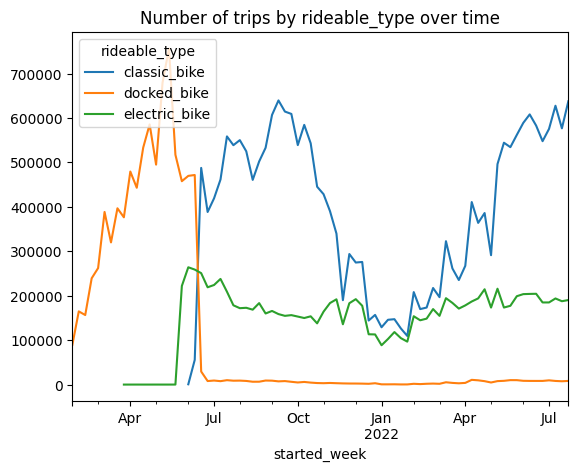

In [7]:
df_distance_traveled_over_time.pivot(index='started_week', columns='rideable_type', values='num').plot(title='Number of trips by rideable_type over time')

We can see that they mostly switched from the term "docked_bike" to "classic_bike" in June 2021 and it seems like it is just e-bike vs normal bike. 

We'll merge the two going forward for simplicity

### What're the possible values for "membership_status"?
Let's do a quick analysis to make sure we loosely understand the values of membership status and whether the data is clean

In [10]:
df_distance_traveled_over_time_mem_stat = pd.read_sql("""select 
date_trunc('week', started_at) as started_week,
membership_status,
avg(power(power(strt.lat - nd.lat, 2) + power(strt.long - nd.long, 2), .5) * 69) as distance,
count(1) num
from prod.trips t
left join prod.stations strt on strt.citi_station_id = t.start_station_id
left join prod.stations nd on nd.citi_station_id = t.end_station_id
group by 1,2""", engine)

<AxesSubplot: xlabel='started_week'>

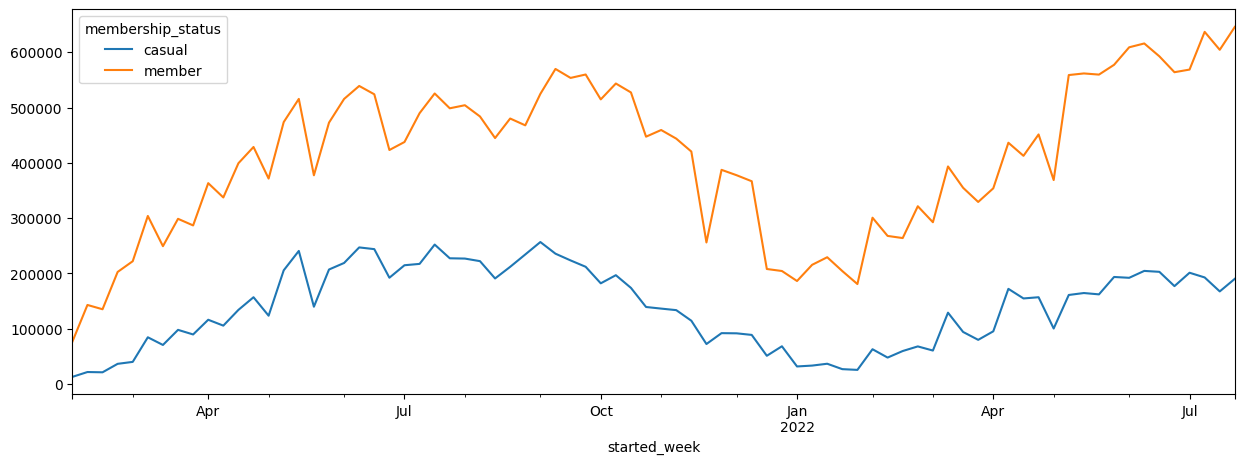

In [12]:
df_distance_traveled_over_time_mem_stat.pivot(index='started_week', columns='membership_status', values='num').plot()

The data above looks largely sane. Interesting sidenote (although somewhat obvious) that casual usage of citibike drops almost to 0 
in winter while membership usage maintains ~40% of their usage

### Distribution of start/end times
While the time looks fairly straightforward lets make sure there isn't dirty data in the start/end times (like crazy dates way out in the future/past)

In [11]:
df_started_at_data_cleaning = pd.read_sql_query("""select date_trunc('hour', started_at) started_at_minute, count(1) num from prod.trips
group by 1""", engine)


df_ended_at_data_cleaning = pd.read_sql_query("""select date_trunc('hour', ended_at) ended_at_minute, count(1) num from prod.trips
group by 1""", engine)

plt.rcParams['figure.figsize'] = [15,5]

<AxesSubplot:title={'center':'Distribution of "started_at" times over time'}, xlabel='started_at_minute'>

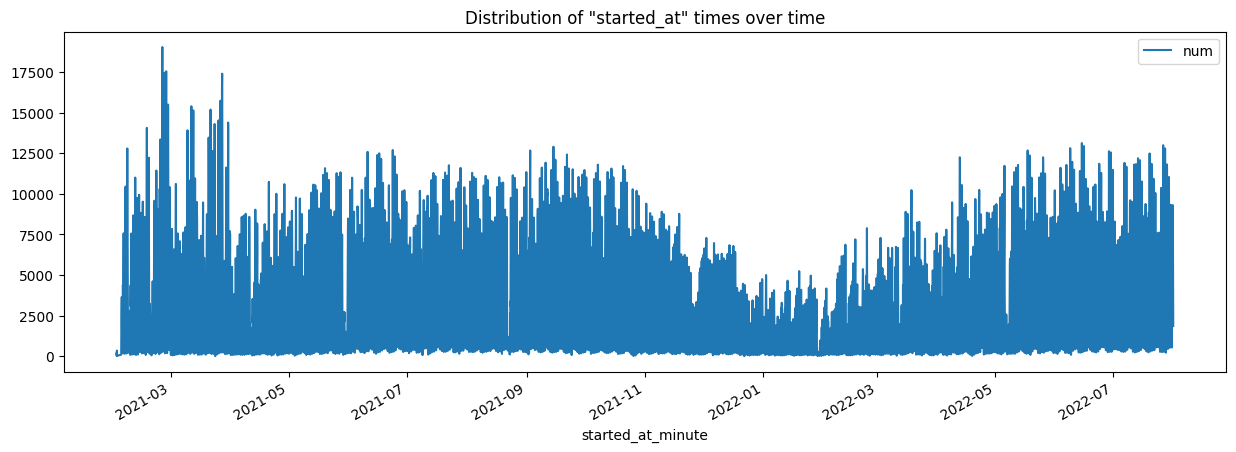

In [21]:
# Check max's and mins
df_started_at_data_cleaning.set_index('started_at_minute').plot(title='Distribution of "started_at" times over time')

In [ ]:
f2.set_index('ended_at_minute').plot(title='Distribution of "ended_at" times over time')

Given that the data was supposed to end in Sept and we see records for Oct we know there's at least some dirty data on the ended times. However looking at the plot above we can see that's a mostly negligable number of trips and shouldn't affect our analysis

### What's the distribution of the trip durations?
While the times look sane, do the start/end times make sense together? Are there trips with an end time before a start time? End time too far out?

In [23]:
df_intervals = pd.read_sql("""select 
	date_trunc('minute', ended_at - started_at) as duration_minutes,
	membership_status,
	count(1) num
from prod.trips
group by 1,2""", engine)

<AxesSubplot:title={'center':'Distribution of trip durations'}, xlabel='duration_minutes'>

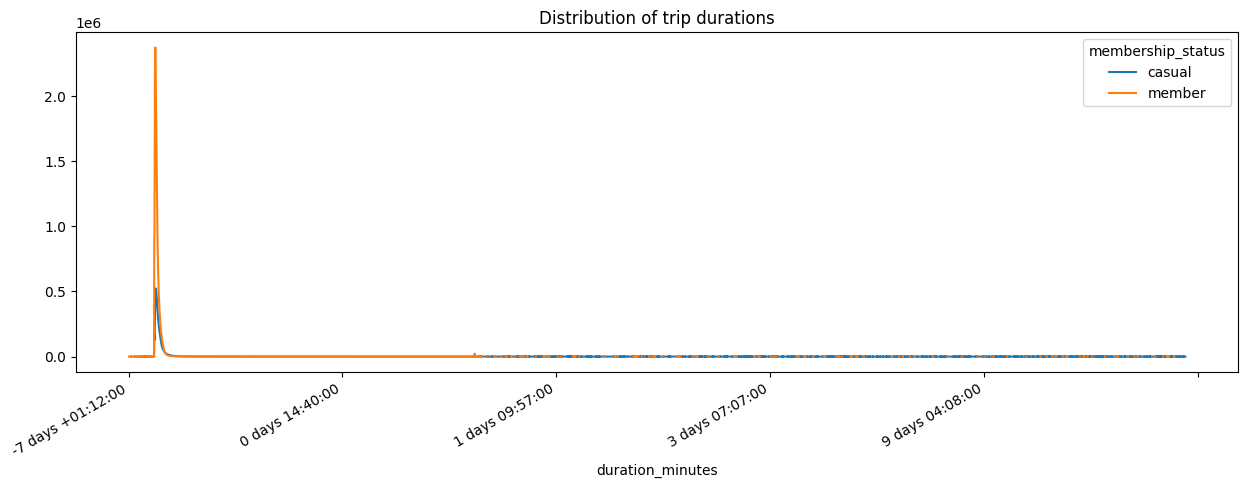

In [26]:
df_intervals.pivot(index='duration_minutes', columns='membership_status', values='num').plot(title='Distribution of trip durations')

Okay, we can see that there are both negative trip durations end times as well as some trips that allegidly last for multiple days.
Let's see how much the dirty data we have will affect our analysis

In [202]:
df_intervals['duration_days'] = (df_intervals['duration_minutes'] / pd.Timedelta('1 day')).astype('int')

In [228]:
tmp = pd.DataFrame(df_intervals.groupby('duration_days')['num'].sum())
tmp['pct_total'] = tmp['num'] / tmp['num'].sum()

In [236]:
tmp[:20]

,num,pct_total
duration_days,,
-6,19,4.093309e-07
-5,9,1.938936e-07
-4,12,2.585248e-07
-3,8,1.723499e-07
-2,14,3.016123e-07
-1,12,2.585248e-07
0,46368284,9.989460e-01
1,45722,9.850226e-04
2,701,1.510216e-05


You can see that 99.8% of rides do happen within 1 day. While that's generally good, .2% dirty data isn't trivial esp with outliers that might drastically affect averages (e.g. average trip length is gonna be skewed by the 13 day trip). We'll filter out all rides shorter than 0 minutes and longer than 2 hours

## So what changes are we making to the data for our analysis?

We've decided we want to make 2 changes to the data:

* Combine 2 of rideable_type fields as we believe they just changed from using one term to another
* Discard any data with a trip duration outside of 0-120 minutes. We'll create a table called prod.trips_cleaned with these changes to the underlying trips table

``` sql
create table prod.trips_cleaned as 
select 
	started_at,
	ended_at,
	start_station_id,
	end_station_id,
	membership_status,
	case when rideable_type = 'docked_bike' then 'classic_bike' else rideable_type end as rideable_type,
filename
from prod.trips
where ended_at - started_at between interval '0' minute and interval '120' minute
```


# On to the analysis!!!

### Let's look at general trends in citibike trips

#### What time do we think is most popular for citibike usage

In [13]:
df_weekday_vs_hours = pd.read_sql("""select date_part('dow', started_at) day_of_week, date_part('hour', started_at) hr, count(1) num from prod.trips_cleaned
group by 1,2""", engine)

In [14]:
df_weekday_vs_hours = df_weekday_vs_hours.astype(int)

In [15]:
df_weekday_vs_hours.pivot(index='hr', columns='day_of_week', values='num').style.background_gradient(cmap ='Reds').set_properties(**{'font-size': '20px'})

day_of_week,0,1,2,3,4,5,6
hr,,,,,,,
0,132044,59713,54556,64403,72949,87489,139024
1,98063,32900,27823,32408,37253,48144,100081
2,69167,19764,16866,18319,21807,28643,74023
3,45407,13299,10857,11760,13597,17550,45594
4,28981,15040,14023,14470,14737,17212,29267
5,20123,41636,49882,50204,46341,43011,22542
6,40259,120264,158458,157267,145929,129634,49597
7,71447,239566,311040,313086,289736,248048,93084
8,122910,353109,447161,455010,425932,358500,160461


<AxesSubplot:xlabel='hr'>

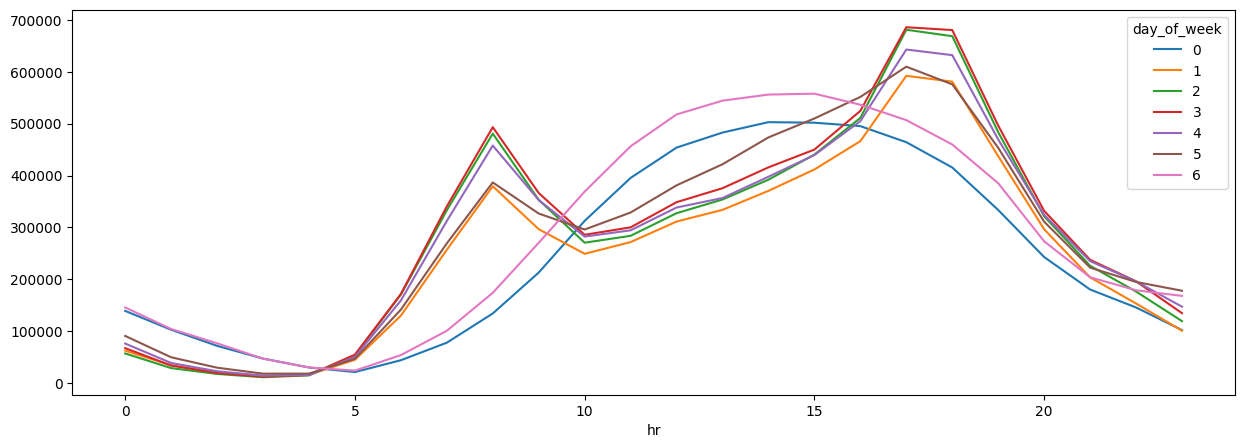

In [53]:
df_weekday_vs_hours.pivot(index='hr', columns='day_of_week', values='num').plot()

## What are the most popular citibike trips?

In [16]:
df_popular_trips = pd.read_sql("""
with t as (
select 
	start_station_id, 
	end_station_id,
	case when start_station_id = end_station_id then true else false end as same_station,
	avg(ended_at - started_at) as trip_time,
	
	count(1) num from prod.trips_cleaned
group by 1,2)

select 
	strt.station_name start_station, 
	nd.station_name end_station, 
	same_station,
	trip_time,
	power(power(strt.lat - nd.lat, 2) + power(strt.long - nd.long, 2), .5) * 69 as distance,
	num from t
left join prod.stations strt on strt.citi_station_id = t.start_station_id
left join prod.stations nd on nd.citi_station_id  = t.end_station_id""", engine)

In [17]:
df_popular_trips.sort_values(by='num', ascending=False)[:20]

,start_station,end_station,same_station,trip_time,distance,num
726614,Central Park S & 6 Ave,Central Park S & 6 Ave,True,0 days 00:30:12.983205,0.000000,20721
735546,7 Ave & Central Park South,7 Ave & Central Park South,True,0 days 00:32:50.820131,0.000000,16512
656238,Roosevelt Island Tramway,Roosevelt Island Tramway,True,0 days 00:34:43.703712,0.000000,12768
773141,5 Ave & E 72 St,5 Ave & E 72 St,True,0 days 00:21:12.482072,0.000000,12411
720139,Grand Army Plaza & Central Park S,Grand Army Plaza & Central Park S,True,0 days 00:24:30.689250,0.000000,11823
702770,12 Ave & W 40 St,12 Ave & W 40 St,True,0 days 00:17:45.704045,0.000000,11076
349255,West St & Chambers St,West St & Chambers St,True,0 days 00:15:02.288290,0.000000,10094
171423,Soissons Landing,Soissons Landing,True,0 days 00:39:22.075699,0.000000,9802
781170,Central Park West & W 72 St,Central Park West & W 72 St,True,0 days 00:24:40.488702,0.000000,9736
31828,West Drive & Prospect Park West,West Drive & Prospect Park West,True,0 days 00:25:27.815762,0.000000,9694


As we see the most popular trips start and end at the same place. **What about trips meant for travel?**

In [18]:
df_popular_trips[df_popular_trips['same_station'] == False][:20]

,start_station,end_station,same_station,trip_time,distance,num
1,67 St & Erik Pl,5 Ave & 66 St,False,0 days 00:14:44.439394,0.285469,198
2,67 St & Erik Pl,4 Ave & Shore Road Dr,False,0 days 00:16:51.634483,0.459942,145
3,67 St & Erik Pl,63 St & 5 Ave,False,0 days 00:22:25.489796,0.307481,49
4,67 St & Erik Pl,3 Ave & Wakeman Pl,False,0 days 00:26:21.657895,0.654898,76
5,67 St & Erik Pl,6 Ave & 60 St,False,0 days 00:11:18.194444,0.382056,72
6,67 St & Erik Pl,62 St & 4 Ave,False,0 days 00:08:07.789474,0.498725,19
7,67 St & Erik Pl,67 St & Ridge Blvd,False,0 days 00:26:42.009901,0.840383,101
8,67 St & Erik Pl,Wakeman Pl & Ridge Blvd,False,0 days 00:21:23.480000,0.820815,25
9,67 St & Erik Pl,55 St & 7 Ave,False,0 days 00:12:07.727273,0.680883,55
10,67 St & Erik Pl,59 St & 5 Ave,False,0 days 00:06:38.296296,0.468624,54


In [19]:
df_trip_time_by_type_of_ride = pd.read_sql("""select 
	date_trunc('day', started_at) as day_started,
	case when start_station_id = end_station_id then true else false end as same_station,
	avg(ended_at - started_at) as trip_time,
	count(1) num from prod.trips_cleaned
group by 1,2""", engine)

### How many trips are "tourist" trips and end at the same dock

<AxesSubplot: xlabel='day_started'>

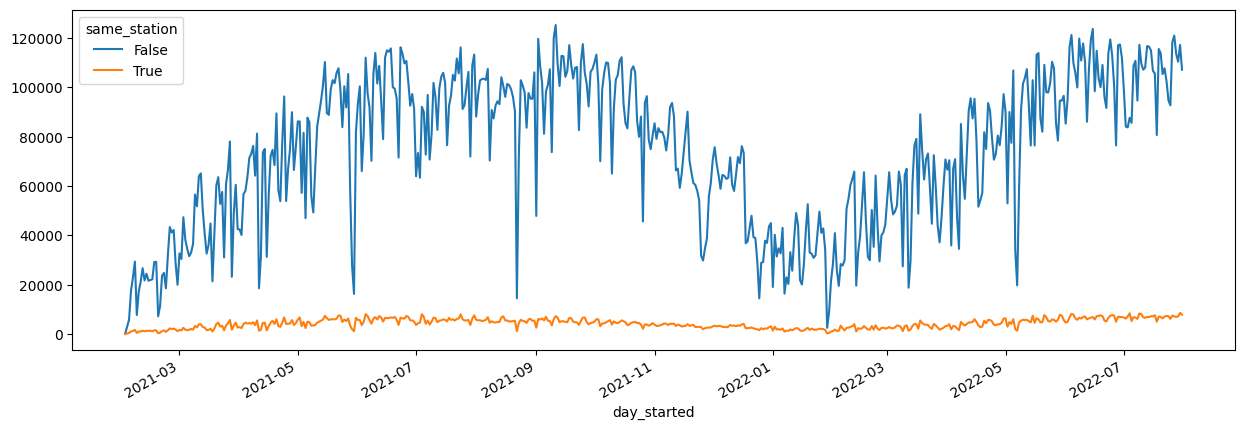

In [20]:
df_trip_time_by_type_of_ride.pivot(index='day_started', columns='same_station', values='num').plot()

### Whats the difference in how long tourists trips use the bike for relative to travel trips?

<AxesSubplot: xlabel='day_started'>

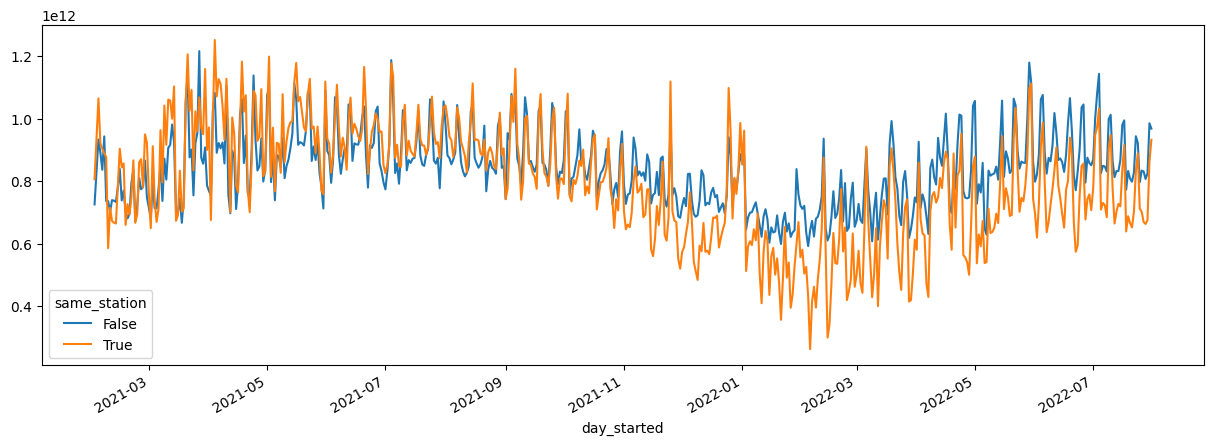

In [22]:
df_trip_time_by_type_of_ride.pivot(index='day_started', columns='same_station', values='trip_time').plot()

# Paretto of how involved stations are. What's the distribution of use of stations

In [23]:
df_involved_stations = pd.read_sql("""with involved_stations as (
	select start_station_id as involved_station from prod.trips_cleaned
	union all
	select end_station_id from prod.trips_cleaned)

select s.station_name, s.lat, s.long, s.first_trip_at, s.last_trip_at, count(1) num from involved_stations i
left join prod.stations s on s.citi_station_id = i.involved_station
group by 1,2,3,4,5""", engine)


In [24]:
df_involved_stations['utility_ratio'] = df_involved_stations['num'] / df_involved_stations['num'].sum()

<AxesSubplot:>

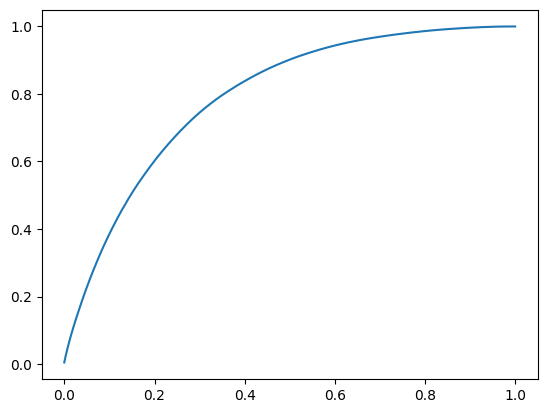

In [ ]:
df2.plot()

## Members vs non_members
Let's investigate the different behaviors of members vs non-members

In [33]:
df_short_rides_member = pd.read_sql_query("""
select 
	membership_status,
	count(1) num
from prod.trips_cleaned
group by 1
""", engine)

<AxesSubplot: xlabel='membership_status'>

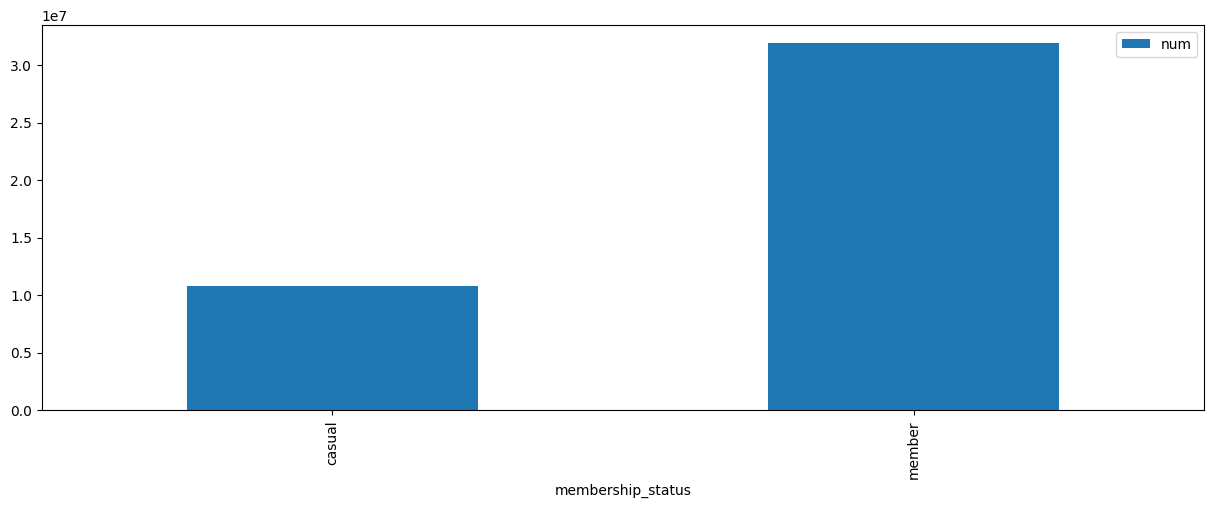

In [40]:
df_short_rides_member.set_index('membership_status').plot.bar()

In [98]:
df_short_rides_membermber_casual = pd.read_sql("""select date_trunc('week', started_at), membership_status, count(1) num from prod.trips
group by 1,2""", engine)
df = df_trips_over_time_member_casual

<AxesSubplot:xlabel='date_trunc'>

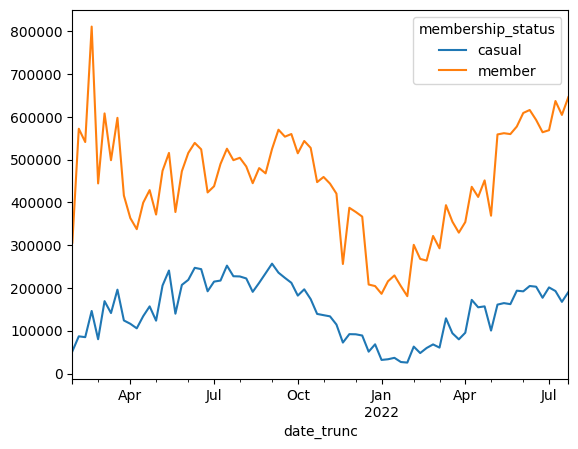

In [99]:
df.pivot(index='date_trunc', columns='membership_status', values='num').plot()

# Stations analysis

## Most popular starting station

In [41]:
df_most_popular_starting_station = pd.read_sql("""
with strt as (
select start_station_id, count(1) num from prod.trips_cleaned
group by 1
)

select s.station_name, s.citi_station_id, s.lat, s.long, strt.num, first_trip_at, last_trip_at from strt
left join prod.stations s on s.citi_station_id = strt.start_station_id""", engine)
df = df_most_popular_starting_station

In [42]:
df.sort_values('num', ascending=False)[:20]

,station_name,citi_station_id,lat,long,num,first_trip_at,last_trip_at
759,W 21 St & 6 Ave,6140.05,40.741739,-73.994155,192085,2021-02-03 12:30:49,2022-07-31 23:36:16
526,West St & Chambers St,5329.03,40.717548,-74.013220,175285,2021-02-03 11:54:34,2022-08-01 17:22:59
997,1 Ave & E 68 St,6822.09,40.765005,-73.958184,165178,2021-02-01 00:20:11,2022-08-01 00:02:20
698,Broadway & E 14 St,5905.12,40.734545,-73.990741,153105,2021-02-01 01:45:35,2022-08-01 12:56:00
832,6 Ave & W 33 St,6364.07,40.749012,-73.988483,152615,2021-02-01 00:09:32,2022-08-01 00:26:33
771,Broadway & W 25 St,6173.08,40.742868,-73.989186,152191,2021-02-03 12:35:47,2022-08-01 00:49:27
586,Cleveland Pl & Spring St,5492.05,40.722103,-73.997249,148196,2021-02-03 13:15:19,2022-08-01 04:29:30
484,West St & Liberty St,5184.08,40.711444,-74.014847,142255,2021-02-01 06:42:40,2022-08-03 17:44:51
699,University Pl & E 14 St,5905.14,40.734814,-73.992085,140885,2021-02-03 12:11:01,2022-07-29 13:28:45
779,E 33 St & 1 Ave,6197.08,40.743226,-73.974497,140012,2021-02-01 00:21:41,2022-07-31 23:45:43


# Comparison of Ebikes to normal bikes

## What's the distribution of trips with different types of bikes in the fleet over time?

## How much further do people take electric bikes

In [47]:
df_dist_traveled_by_type = pd.read_sql("""select 
date_trunc('week', started_at) as started_week,
rideable_type,
avg(power(power(strt.lat - nd.lat, 2) + power(strt.long - nd.long, 2), .5) * 69) as distance,
count(1) num
from prod.trips_cleaned t
left join prod.stations strt on strt.citi_station_id = t.start_station_id
left join prod.stations nd on nd.citi_station_id = t.end_station_id
group by 1,2""", engine)

<AxesSubplot: xlabel='started_week'>

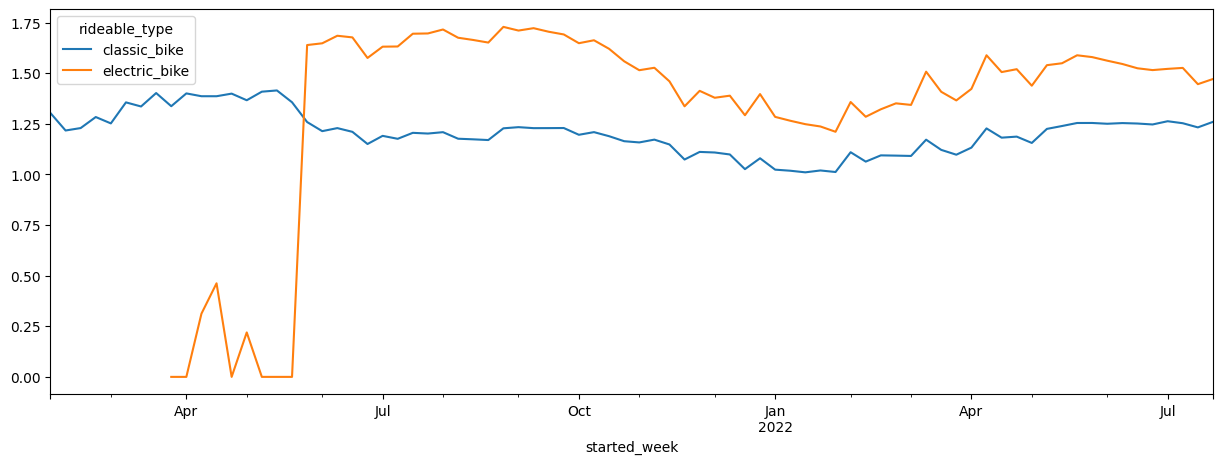

In [48]:
df_dist_traveled_by_type.pivot(index='started_week', columns='rideable_type', values='distance').plot()

# Single station experience
## Let's hone in on the experience of a single station


In [49]:
df_single_station_data = pd.read_sql("""
select 
	'start_station' as station_type,
	date_part('dow', started_at) day_of_week, 
	date_part('hour', started_at) hr, 
	count(1) num from prod.trips_cleaned
where start_station_id = '{station_id}'
group by 1,2,3
union all
select 
	'end_station' as station_type,
	date_part('dow', started_at) day_of_week, 
	date_part('hour', started_at) hr, 
	count(1) num from prod.trips_cleaned
where end_station_id = '{station_id}'
group by 1,2,3""".format(station_id='4033.06'), engine)




### Rides _start_ at this station on this distribution

<AxesSubplot: xlabel='hr'>

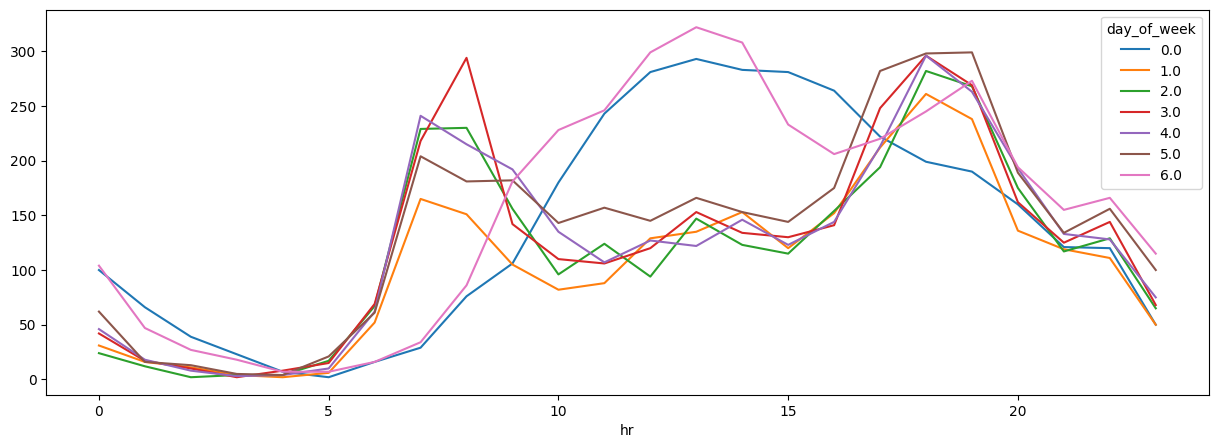

In [54]:
df_single_station_data[df_single_station_data['station_type'] == 'start_station'][['day_of_week', 'hr', 'num']].pivot(index='hr', columns='day_of_week', values='num').plot()

### Rides end on the station with _this_ distribution

<AxesSubplot: xlabel='hr'>

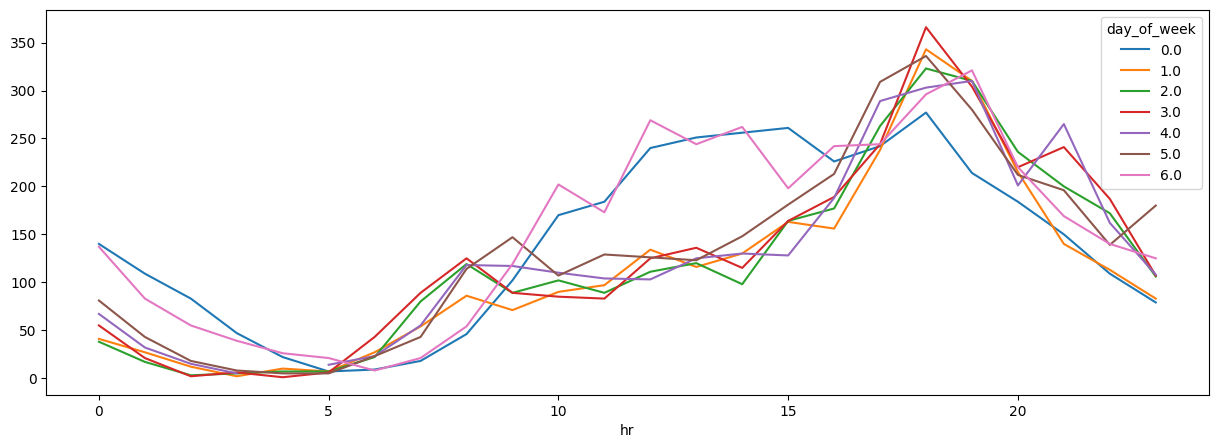

In [53]:
df_single_station_data[df_single_station_data['station_type'] == 'end_station'][['day_of_week', 'hr', 'num']].pivot(index='hr', columns='day_of_week', values='num').plot()

### Stations with most asymetric number of trips starting vs ending there

In [56]:
df_asymetric_stations = pd.read_sql("""with starts as (
	select start_station_id, count(1) num from prod.trips_cleaned
	where start_station_id != 'None'
	group by 1),
	
ends as (
	select end_station_id, count(1) num from prod.trips_cleaned
	where end_station_id != 'None'
	group by 1
)

select 
	coalesce(starts.start_station_id, ends.end_station_id) as station_id,
	s.station_name,
	coalesce(starts.num, 0) as starts_num, 
	coalesce(ends.num, 0) as ends_num,
	coalesce(ends.num, 0) - coalesce(starts.num, 0) as additional_bikes
from starts
full outer join ends on ends.end_station_id = starts.start_station_id
left join prod.stations s on s.citi_station_id = starts.start_station_id
order by additional_bikes """, engine)

### Top stations with people asymetrically starting rides there, but not ending them there
(E.g. Stations most likely to be empty)

In [59]:
df_asymetric_stations.sort_values('additional_bikes')[:20]

,station_id,station_name,starts_num,ends_num,additional_bikes
0,7023.04,W 59 St & 10 Ave,80463,72806,-7657
1,6756.05,W 44 St & 11 Ave,86878,80814,-6064
2,6890.06,W 50 St & 10 Ave,58570,52698,-5872
3,4010.01,Plaza St East & Flatbush Ave,46090,40516,-5574
4,6747.06,W 49 St & 8 Ave,90478,85180,-5298
5,7409.08,W 84 St & Broadway,48134,43088,-5046
6,6948.1,Broadway & W 58 St,122202,117229,-4973
7,6364.1,6 Ave & W 34 St,125957,121419,-4538
8,7281.09,W 76 St & Columbus Ave,53861,49360,-4501
9,5476.03,E 2 St & Avenue C,81643,77311,-4332


### Top stations with people asymetrically ending rides there, but not starting them there
(E.g. Stations most likely to be full)

In [117]:
df.sort_values('additional_bikes', ascending=False)[:20]

,station_id,station_name,starts_num,ends_num,additional_bikes
1748,5489.03,Kent Ave & N 7 St,99001,103192,4191
1747,5532.01,Mercer St & Spring St,70635,74424,3789
1746,5980.07,E 17 St & Broadway,157002,160101,3099
1745,7617.07,Central Park North & Adam Clayton Powell Blvd,91833,94923,3090
1744,5453.01,Rivington St & Chrystie St,63559,66470,2911
1743,5679.05,Mercer St & Bleecker St,64662,67535,2873
1742,5687.04,MacDougal St & Prince St,75655,78408,2753
1741,6190.08,9 Ave & W 18 St,72129,74817,2688
1740,5905.14,University Pl & E 14 St,154278,156925,2647
1739,5125.03,S 5 Pl & S 5 St,97679,100189,2510


The above stations are loosely supported by spot checking street view. The stations with a high "additional bikes" count tend to be full in streetview and those with a large deficit tend to be empty